# **Maintenance Dredging**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.options.display.float_format = '{:,}'.format# show , for thousands
pd.set_option('display.max_columns', 1000)# show all columns

from pathlib import Path

# change the width of the cells on screen 
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

,Hs [m]
time,
2012-01-01 00:00:00,1.492622729
2012-01-01 01:00:00,1.564041114
2012-01-01 02:00:00,1.609562006
2012-01-01 03:00:00,1.636151964
2012-01-01 04:00:00,1.638944871


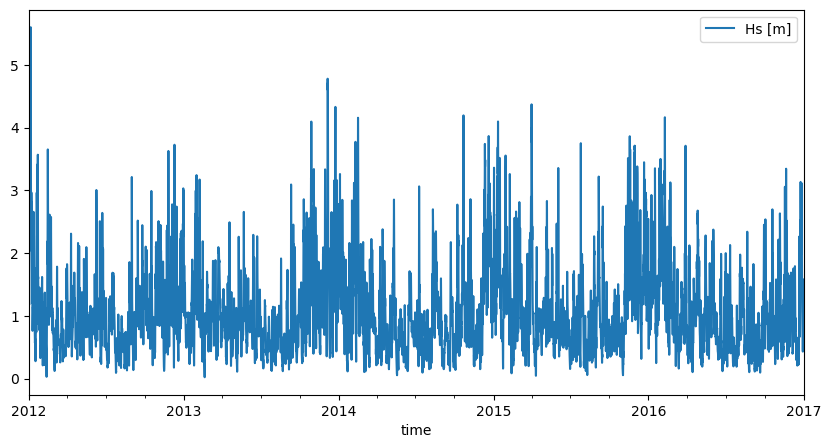

In [2]:
path = Path.cwd()
eurpfm = pd.read_csv(Path.joinpath(path, "Waves_Safe_Haven.csv"), delimiter = ',')
eurpfm['time'] = pd.to_datetime(eurpfm['time'])
eurpfm.set_index(['time'], inplace = True)

display(eurpfm.head(5))
eurpfm.plot(figsize=(10,5),subplots=True);

In [6]:
mean_overal = eurpfm.mean()
print('Mean')
print(mean_overal, "\n", )

print('Standard deviation')
std_overal = eurpfm.std()
print(std_overal)

Mean
Hs [m]   1.061542415649114
dtype: float64 

Standard deviation
Hs [m]   0.6874802644209435
dtype: float64


NameError: name 'months' is not defined

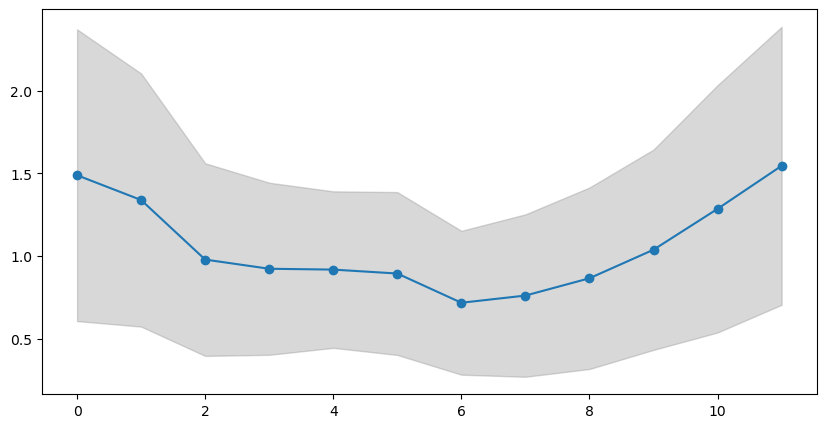

In [7]:
# Group by month (1-12) and calculate mean and std dev for each calendar month across all years
# (monthly_mean and monthly_std already exist)
monthly_mean = eurpfm.groupby(eurpfm.index.month).mean()
monthly_std = eurpfm.groupby(eurpfm.index.month).std()

plt.figure(figsize=(10,5))
plt.plot(monthly_mean.index-1, monthly_mean['Hs [m]'], marker='o', label='Monthly Mean')
plt.fill_between(monthly_mean.index-1,
                 monthly_mean['Hs [m]'] - monthly_std['Hs [m]'],
                 monthly_mean['Hs [m]'] + monthly_std['Hs [m]'],
                 color='gray', alpha=0.3, label='Mean ± Std Dev')
plt.xticks(ticks=range(12), labels=months)
plt.xlabel('Month')
plt.ylabel('Hs [m]')
plt.title('Monthly Mean and Standard Deviation of Hs [m]')
plt.legend()
plt.grid(True)
plt.show()


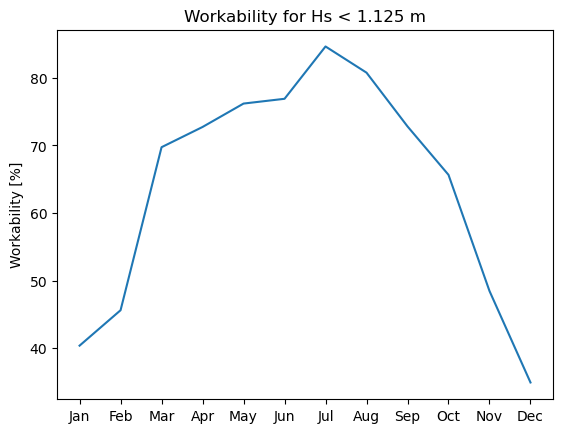

In [8]:

draught= 4.5  #CHANGE WITH BOATS
Hs_thres = 0.25 *draught  #CHANGE WITH BOAT DRAUGHT
work_ability = []

for month in range(1,12+1,1):
    data_month = eurpfm[eurpfm.index.month == month].copy()
    n_all = len(data_month)
    
    data_month = data_month[data_month['Hs [m]'] <= Hs_thres]
    n_workable = len(data_month)
    
    work_ability.append(n_workable/n_all*100)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.plot(work_ability);
plt.xticks(np.linspace(0,11,12), months);
plt.title('Workability for Hs < '+str(Hs_thres)+' m');
plt.ylabel('Workability [%]');

# Persistency

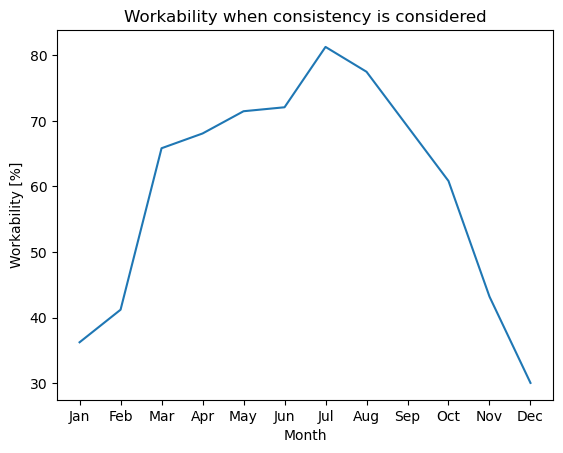

In [9]:
month_assessed = np.zeros(12)# an array that counts how many times each month is reviewed.
month_succes = np.zeros(12)# an array that will count the number of time 6 consequetive hours are occuring


for i in range(len(eurpfm)):
    period = eurpfm.iloc[i:i+6]
    
    month = period.index[0].month
    month_assessed[month-1] += 1# to zero-based

    Hs_serie = period['Hs [m]'].values.tolist()
 
    if np.max(Hs_serie) <= Hs_thres:    
        month_succes[month-1] += 1  # to zero-based
        #print(i, 'succes, Hs', np.max(Hs_serie))
    #else:
    #    print(i, 'not succes, Hs', np.max(Hs_serie), 'Wl min', np.min(WL_serie))

workability = month_succes/month_assessed*100

plt.plot(workability)
plt.title('Workability when consistency is considered')
plt.xticks(np.linspace(0,11,12), months);
plt.xlabel('Month')
plt.ylabel('Workability [%]');

**Using THSD Easydredge 1700 - calculate the production and how much time to dredge 5 m deep sand sediment**

In [ ]:
Hopper_capacity = 1700 # m3
suction_diameter = 600 #mm
Power = 701 #kW dredge pump diesel engine
v_TSHD = 10.3 #knots 
v = 3 #m/s
fraction_sand = 0.35

Prod_pipe = v*0.25*np.pi*(suction_diameter/1000)**2 # v*A
Production = 2282.4 # m3/h

print('The production of the pipe is',round(Prod_pipe*3600,1), 'm3/h.')
Load_time = Hopper_capacity/Prod_pipe/3600

print('The loading time is when soil can be diluted with water - overflow is not considered', round(Load_time*3600,1), 's =', round(Load_time,3), 'h')

The production of the pipe is 3053.6 m3/h.
The loading time is when soil can be diluted with water - overflow is not considered 2004.2 s = 0.557 h


In [33]:
def tshd_hourly_production(hopper_capacity_m3, load_factor, overflow_loss, cycle_time_hr, in_situ_density_t_m3):

    volume_production = hopper_capacity_m3 * load_factor * (1 - overflow_loss) / cycle_time_hr

    # Hourly production in tonnes
    mass_production = volume_production * in_situ_density_t_m3

    return volume_production, mass_production

load_factor = 0.95            
overflow_loss = 0.10      
cycle_time = 2.0 
in_situ_density = 2.0  

# Run the calculation
Qv, Qt = tshd_hourly_production(Hopper_capacity, load_factor, overflow_loss, cycle_time, in_situ_density)

print(f"Hourly production (volume): {Qv:,.0f} m³/hr")
print(f"Hourly production (mass):   {Qt:,.0f} tonnes/hr")


Hourly production (volume): 727 m³/hr
Hourly production (mass):   1,454 tonnes/hr


**Sedimentation rate & dredging cycle**

In [11]:
initial_depth = 13.0
total_sedimentation_kg = 0
weeks = 52 * 10 # 10 years
d_min = 8 #m
ro_sand = 2000 # kg/m3
ro_water = 1000 # kg/m3
channel_width = 220 #m

def V_trench(B,H,phi,L):#phi in degrees, B = bottom width, H = layer thickness
    phi_rad = phi*np.pi/180
    A = H*(B+H/np.tan(phi_rad))*L
    B1 = B + 2*H/np.tan(phi_rad)
    return A,B1
      
# sand layer
V_sand, B_top_sand = V_trench(B = 220,H = 5,phi = 30, L=1000) 
print('Sand:', round(V_sand,0) ,'m3, top width:', round(B_top_sand,0), 'm')

Sand: 1143301.0 m3, top width: 237.0 m


Depth reached 8 m at week 313


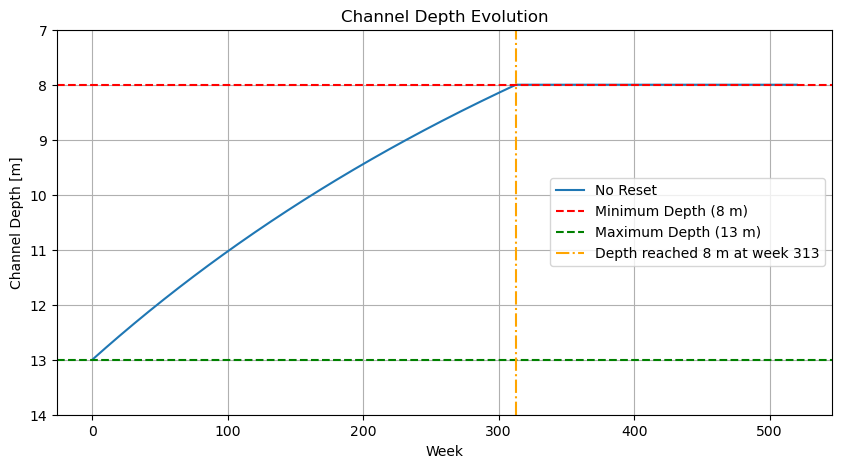

In [12]:
depths = [initial_depth]
current_depth = initial_depth
total_sedimentation_m3 = 0

L = 1000  # channel length in meters (used in V_trench above)
area = channel_width * L  # cross-sectional area for sedimentation calculation

# Loop WITHOUT resetting the depth after 5 years
depths_no_reset = [initial_depth]
current_depth_no_reset = initial_depth
total_sedimentation_m3_no_reset = 0

for week in range(weeks):
    sedimentation_kg = (250 + 260 * current_depth_no_reset**1.4) * L  # Kg/week
    sedimentation_m3 = sedimentation_kg / ro_sand  # m3/week
    total_sedimentation_m3_no_reset += sedimentation_m3
    delta_depth = sedimentation_m3 / area
    current_depth_no_reset -= delta_depth
    if current_depth_no_reset < d_min:
        current_depth_no_reset = d_min  # prevent going below minimum
    depths_no_reset.append(current_depth_no_reset)
    if current_depth_no_reset == d_min and depths_no_reset[-2] > d_min:
        print(f"Depth reached {d_min} m at week {week+1}")

# Loop WITH resetting the depth after 5 years (week 260)
depths_reset = [initial_depth]
current_depth_reset = initial_depth
total_sedimentation_m3_reset = 0

for week in range(weeks):
    if week == 260:
        current_depth_reset = initial_depth  # reset depth after 5 years
    sedimentation_kg = (250 + 260 * current_depth_reset**1.4) * L  # Kg/week
    sedimentation_m3 = sedimentation_kg / ro_sand  # m3/week
    total_sedimentation_m3_reset += sedimentation_m3
    delta_depth = sedimentation_m3 / area
    current_depth_reset -= delta_depth
    if current_depth_reset < d_min:
        current_depth_reset = d_min  # prevent going below minimum
    depths_reset.append(current_depth_reset)

# Plot both scenarios
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(depths_no_reset)), depths_no_reset, label='No Reset')
#plt.plot(np.arange(len(depths_reset)), depths_reset, label='Reset at week 260')
plt.xlabel('Week')
plt.ylabel('Channel Depth [m]')
plt.title('Channel Depth Evolution')
plt.ylim(7,14)
plt.axhline(y=d_min, color='r', linestyle='--', label='Minimum Depth (8 m)')
plt.axhline(y=initial_depth, color='g', linestyle='--', label='Maximum Depth (13 m)')
plt.axvline(x=313, linestyle='-.', label ='Depth reached 8 m at week 313', color='orange')
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.show()